THINGS TO CHECK
- check rescale
- load on demand vs load on init

In [1]:
import sys
sys.path.append('../src')

import albumentations as A
import random
import numpy as np
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation, OneFormerConfig
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from safetensors.torch import load_model, save_model
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *
from utils import *

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
torch.cuda.is_available()

True

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
id2label, label2id = get_id2label_mappings()

config = OneFormerConfig.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny", 
                                         num_classes = len(id2label),
                                         id2label = id2label,
                                         label2id = label2id,
                                         is_training=True)


/home/panzaresce/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# model_card = "shi-labs/oneformer_coco_dinat_large"
model_card = "shi-labs/oneformer_ade20k_swin_tiny"
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
processor = OneFormerProcessor.from_pretrained(model_card)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [6]:
# Uncomment to load from fine-tuned model
# load_model(model, "../safetensors/model.safetensors")

In [5]:
# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

In [6]:
MAIN_PROJECT_DIR

'/home/panzaresce/repos/galaxy_segmentation'

In [7]:
# Augmentations
transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.OneOf([
                A.Rotate(limit=(90), p=1),
                A.Rotate(limit=(180), p=1),
                A.Rotate(limit=(270), p=1)
            ], p=1),
            # A.MultiplicativeNoise((0.9, 1.1), False, True, p=0.5)
        ]),
        A.NoOp()
    ], p=1.0)
])

In [8]:
dataset_train = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [12]:
dataset_val = GalaxyDataset(DATASET_DIR, "val", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [13]:
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [8]:
dataset_sub = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=20)

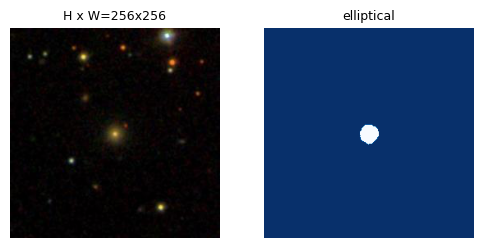

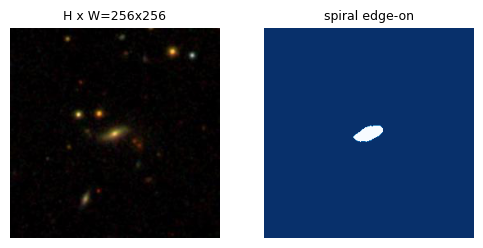

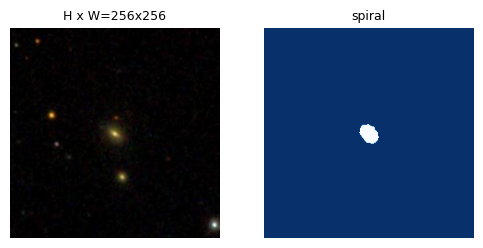

In [9]:
display_n_samples(dataset_train, 3)

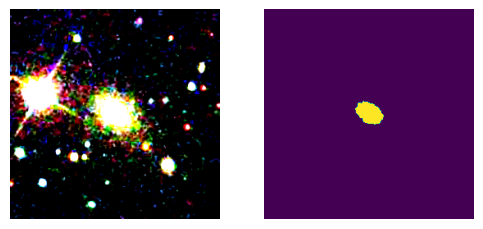

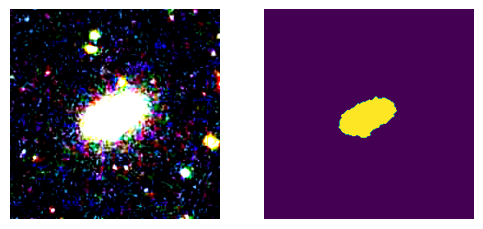

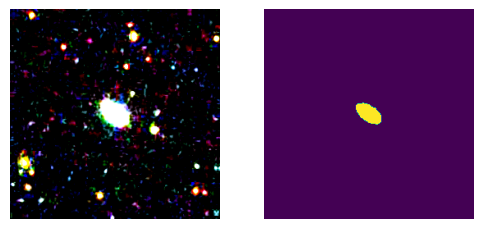

In [10]:
display_n_samples(dataset_train, 3, False)

In [13]:
batch_size = 2
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [13]:
train_dataloader = DataLoader(dataset_sub, batch_size=1, shuffle=True)

In [ ]:
# Test check for empty masks
# TODO: make a test.py file
for idx, el in enumerate(dataset_train):
    # print(idx)
    if el["pixel_mask"].unique().shape[0] != 1:
        print(f"{idx}: {el["pixel_mask"].unique()}")
    if el["mask_labels"].shape[0] != 2:
        print("FOUND WRONG LABELS")
        print(f"{idx}: {el["mask_labels"].shape[0]}")

In [8]:
# Configuration for recovering execution, input argument of train_script.py
recover_exec = False
n_epochs = 20
end_epoch = 20

In [ ]:
starting_epoch = 0
verbose = False

device = "cuda" if torch.cuda.is_available() else "cpu"

tr_loss = []
val_loss = []
lr_list = []

# Hyperparameters
weight_decay = 0.1
base_lr = 1e-4
grad_clip = 1

dataset_sub.set_task("random")

if recover_exec:
    with open(os.path.join(MAIN_PROJECT_DIR, "safetensors/galaxy_train.json")) as json_data:
        rec = json.load(json_data)
    last_iteration = rec["last_iteration"]
    starting_epoch = rec["last_epoch"]
    lr = float(rec["last_lr"])
    print(f"Recovering execution from epoch {starting_epoch} | lr={lr}")
    load_model(model, os.path.join(MAIN_PROJECT_DIR, "safetensors/galaxy.safetensors"))

model.to(device)

# Scheduler and Optimizer
warmup_iters = 10
optimizer = AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
# sched = WarmupPolyLR(optimizer, len(dataset_train)*n_epochs, warmup_iters=warmup_iters, warmup_factor=0.01)
sched = WarmupPolyLR(optimizer, len(dataset_sub)*n_epochs, warmup_iters=warmup_iters, warmup_factor=0.01)

if recover_exec:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    sched.last_epoch = last_iteration
    sched._last_lr = [group['lr'] for group in optimizer.param_groups]

# print(f"Sched --> last_epoch: {sched.last_epoch} | max_iters: {sched.max_iters} | power: {sched.power} | base_lrs: {sched.base_lrs}")

print(f"Training in {dataset_sub.task} mode")

for epoch in range(starting_epoch, end_epoch):
    print(f"Epoch {epoch}")
    training_mode(model)


    for batch_idx, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        
        tr_loss.append(outputs.loss.item())

        outputs.loss.backward()
        norm = clip_grad_norm_(model.parameters(), grad_clip)

        # print every 5% of progress
        # if (batch_idx + 1) % (len(train_dataloader) // 20) == 0 or batch_idx < 10 or verbose:
        print(f"Loss at iteration n. {(batch_idx + 1)} / {len(train_dataloader)}: {outputs.loss.item()} | lr: {sched.get_last_lr()} | norm: {norm:.6f}")

        # print(f"Last epoch: {sched.last_epoch}")    
        optimizer.step()
        sched.step()
    
    # Validation loop
    # evaluation_mode(model)
    # val_running_loss = 0.0
    # print("Validation loop")
    # for batch_idx, batch in enumerate(val_dataloader):
    #     batch = {k:v.to(device) for k,v in batch.items()}
        
    #     with torch.no_grad():
    #         outputs = model(**batch)
    #     val_running_loss += outputs.loss.item()
    
    # val_loss.append(val_running_loss / len(val_dataloader) * batch_size)
    # print(f"Validation loss at epoch {epoch}: {val_loss[-1]}")

# save_model(model, os.path.join(MAIN_PROJECT_DIR, "safetensors/galaxy.safetensors"))

# print(f"Sched --> last_epoch: {sched.last_epoch} | max_iters: {sched.max_iters} | power: {sched.power} | base_lrs: {sched.base_lrs}")

# Save json to recover training later
# if end_epoch != n_epochs:
#     print("Saving json...")
#     with open(os.path.join(MAIN_PROJECT_DIR, "safetensors/galaxy_train.json"), "w") as fp:
#         rec = {"last_lr": sched.get_last_lr()[0], "last_iteration": sched.last_epoch, "last_epoch": end_epoch}
#         json.dump(rec , fp)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)
model.to(device)

for batch_idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(**batch)

    break
# print(processor.tokenizer.batch_decode(batch["task_inputs"][0]))
# print(processor.tokenizer.batch_decode(batch["task_inputs"][1]))
# batch["class_labels"]

In [13]:
dataset_sub = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=20)

In [14]:
run_iou, run_dice, run_acc, confusion_matrix = compute_metrics(dataset_sub, model, processor, len(id2label))
print(f"mIoU: {run_iou / len(dataset_sub):.4f}")
print(f"Dice: {run_dice / len(dataset_sub):.4f}")
print(f"Accuracy: {run_acc / len(dataset_sub):.4f}")

Using task semantic
mIoU: 0.5757
Dice: 0.6095
Accuracy: 0.6500


In [25]:
map = compute_meanap(model, processor, dataset_sub)
print(f"AP (at IoU=.50:.05:.95) = {map:.4f}")

Using task instance
AP (at IoU=.50:.05:.95) = 0.0000


In [110]:
image_info = dataset_sub.image_info[6]
image = skimage.io.imread(image_info['path'])
mask = dataset_sub.load_mask(image_info)

# Apply transform augmentation

transformed_image = image
transformed_mask = mask

# Squeeze is necessary because the image processor expects ndims=2
transformed_mask = np.squeeze(transformed_mask)

# Apply the processor to the image and masks
encoded_inputs = processor(
    images=transformed_image,
    task_inputs=["instance"],
    segmentation_maps=transformed_mask,
    return_tensors="pt",
    image_mean=GALAXY_MEAN,
    image_std=GALAXY_STD
)

encoded_inputs2 = processor(
    images=transformed_image,
    task_inputs=["semantic"],
    segmentation_maps=transformed_mask,
    return_tensors="pt",
    image_mean=GALAXY_MEAN,
    image_std=GALAXY_STD
)

inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k, v in encoded_inputs.items()}
inputs2 = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k, v in encoded_inputs2.items()}

# Pad mask_labels and class_labels
dim = dataset_sub.max_obj - inputs["mask_labels"].shape[0]
inputs["mask_labels"] = F.pad(inputs["mask_labels"], (0, 0, 0, 0, dim, 0), "constant", 1)
inputs["class_labels"] = F.pad(inputs["class_labels"], (dim, 0), "constant", 0)

dim = dataset_sub.max_obj - inputs2["mask_labels"].shape[0]
inputs2["mask_labels"] = F.pad(inputs2["mask_labels"], (0, 0, 0, 0, dim, 0), "constant", 1)
inputs2["class_labels"] = F.pad(inputs2["class_labels"], (dim, 0), "constant", 0)

instance {'background': 0, 'elliptical': 0, 'spiral': 0, 'spiral barred': 0, 'spiral edge-on': 1, 'artifact': 0}
instance (1, 256, 256)
instance [0. 1.] 65206 330
out (1, 256, 256) [0. 1.] 65206 330
sem {'background': 1, 'elliptical': 0, 'spiral': 0, 'spiral barred': 0, 'spiral edge-on': 1, 'artifact': 0}
sem (2, 256, 256)
out (2, 256, 256) [0. 1.] 65536 65536


In [56]:
transformed_mask

array([0, 4], dtype=uint8)

In [21]:
dataset_sub[5]["pixel_mask"].unique()

tensor([1])

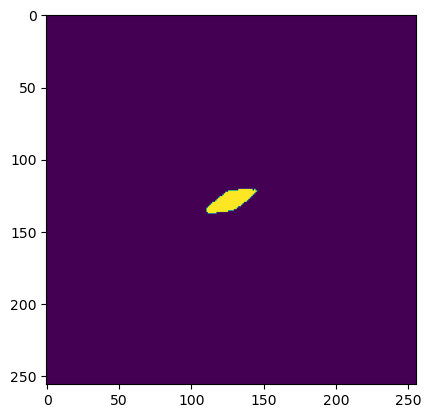

In [114]:
plt.imshow(inputs["mask_labels"][1])
# inputs["mask_labels"][1]
# print(inputs["mask_labels"][0].unique(), inputs["class_labels"][0])
# print(inputs2["mask_labels"][0].unique(), inputs2["class_labels"][0])

In [106]:
a = np.array([[0,0,0,0,0], [0,0,0,0,1]])
np.count_nonzero(a == 0)

9